In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

In [2]:
def create_dictionary(text):
    """Create a dictionary from the text data.
        Args:
            text: List of strings, the text data.
        Returns:
            char_to_int: dict, a dictionary mapping characters to integers.
            int_to_char: dict, a dictionary mapping integers to characters.
    """
    chars = sorted(list(set(text)))
    char_to_int = {c: i for i, c in enumerate(chars)}
    int_to_char = {i: c for i, c in enumerate(chars)}
    return chars, char_to_int, int_to_char

def create_dataset(max_length, text, char_to_int):
    """Create a dataset from the text data.
        Args:
            max_length: int, the length of the input sequence.
            text: List of strings, the text data.
            char_to_int: dict, a dictionary mapping characters to integers.
        Returns:
            X: np.array, the input sequences.
            y: np.array, the target characters.
    """
    X = []
    y = []
    for i in range(len(text) - max_length):

        sequence = text[i:i + max_length]
        label = text[i + max_length]
        X.append([char_to_int[char] for char in sequence])
        y.append(char_to_int[label])

    X = np.array(X)
    y = np.array(y)

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train = torch.tensor(X_train, dtype=torch.long)
    y_train = torch.tensor(y_train, dtype=torch.long)
    X_val = torch.tensor(X_val, dtype=torch.long)
    y_val = torch.tensor(y_val, dtype=torch.long)
    return X_train, y_train, X_val, y_val


In [3]:
# Defining the Transformer model
class CharTransformer(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, nhead):
        super(CharTransformer, self).__init__()
        self.embedding = nn.Embedding(input_size, hidden_size)
        encoder_layers = nn.TransformerEncoderLayer(hidden_size, nhead)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        embedded = self.embedding(x)
        transformer_output = self.transformer_encoder(embedded)
        output = self.fc(transformer_output[:, -1, :])  # Get the output of the last Transformer block
        return output

In [31]:
def train(model, X_train, y_train, X_val, y_val, epochs, batch_size, learning_rate, device):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train_losses = []
    val_losses = []
    val_accuracys = []
    for epoch in range(epochs):
        model.train()
        X_train = X_train.to(device)
        y_train = y_train.to(device)
        
        optimizer.zero_grad()
        output = model(X_train)
        loss = criterion(output, y_train)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        model.eval()
        with torch.no_grad():
            X_val = X_val.to(device)
            y_val = y_val.to(device)
            val_output = model(X_val)
            val_loss = criterion(val_output, y_val)
            _, val_preds = torch.max(val_output, 1)
            val_accuracy = (val_preds == y_val).float().mean()
            val_losses.append(val_loss.item())
            val_accuracys.append(val_accuracy.item())
        if (epoch+1) % 10 == 0:
            print(f"Epoch: {epoch+1}, Train Loss: {loss.item()}, Val Loss: {val_loss.item()}, Val Accuracy: {val_accuracy.item()}")
    
    return train_losses, val_losses, val_accuracys

def predict_next_char(model, char_to_ix, ix_to_char, initial_str, max_length, device):
    model.eval()
    with torch.no_grad():
        initial_input = torch.tensor([char_to_ix[c] for c in initial_str[-max_length:]], dtype=torch.long).unsqueeze(0)
        prediction = model(initial_input)
        predicted_index = torch.argmax(prediction, dim=1).item()
        return ix_to_char[predicted_index]

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [16]:
text = open('txt.txt', 'r').read()
chars, char_to_int, int_to_char = create_dictionary(text)
X_train, y_train, X_val, y_val = create_dataset(10, text, char_to_int)

In [34]:
import time
def get_results(X_val, y_val, char_to_int, int_to_char,
                max_length, hidden_size, num_layers, nhead, device='cuda'):


    X_train, y_train, X_val, y_val = create_dataset(max_length, text, char_to_int)
    model = CharTransformer(len(chars), hidden_size, len(chars), num_layers, nhead)
    time_1 = time.time()
    train_losses, val_losses, val_accuracys = train(model, X_train, y_train, X_val, y_val, epochs=100, batch_size=32, learning_rate=0.001, device=device)
    time_2 = time.time()
    figure, ax = plt.subplots(1, 2, figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(val_accuracys, label='Val Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # target_str =  "This is a simple example to demonstrate how to predict the next char"
    # predicted_results = []
    # for i in range(50):
        # if predicted_results:
            # target_str = target_str + predicted_results[-1]
        # predicted_results.append(predict_next_char(model, char_to_int, int_to_char, target_str, max_length, device))
    
    print("==========================================resutls==========================================")
    # print(f'model type: {}, hidden size: {hidden_size}')
    print(f'final training loss: {train_losses[-1]}, final validation loss: {val_losses[-1]}, final validation accuracy: {val_accuracys[-1]}')
    # print(f'results:{target_str}')
    print(f'Average running time" {(time_2 - time_1)/ 100}')
    print(f'model complexity(number of parameters): {count_parameters(model)}')
    print("===========================================================================================")
    # return train_losses, val_losses, val_accuracys


c:\Users\lzhang51\.conda\envs\pytorch\Lib\site-packages\torch\nn\modules\transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch: 10, Train Loss: 2.5438578128814697, Val Loss: 2.547924280166626, Val Accuracy: 0.24528300762176514
Epoch: 20, Train Loss: 2.379014253616333, Val Loss: 2.469127893447876, Val Accuracy: 0.25995805859565735
Epoch: 30, Train Loss: 2.277832269668579, Val Loss: 2.4280450344085693, Val Accuracy: 0.2788259983062744
Epoch: 40, Train Loss: 2.238828659057617, Val Loss: 2.3901963233947754, Val Accuracy: 0.26624736189842224
Epoch: 50, Train Loss: 2.210602283477783, Val Loss: 2.3784353733062744, Val Accuracy: 0.2704402506351471
Epoch: 60, Train Loss: 2.1973319053649902, Val Loss: 2.385481357574463, Val Accuracy: 0.276729553937912
Epoch: 70, Train Loss: 2.1973066329956055, Val Loss: 2.387134075164795, Val Accuracy: 0.2704402506351471
Epoch: 80, Train Loss: 2.1876323223114014, Val Loss: 2.386215925216675, Val Accuracy: 0.2788259983062744
Epoch: 90, Train Loss: 2.1745822429656982, Val Loss: 2.3919217586517334, Val Accuracy: 0.276729553937912
Epoch: 100, Train Loss: 2.182239532470703, Val Loss: 2

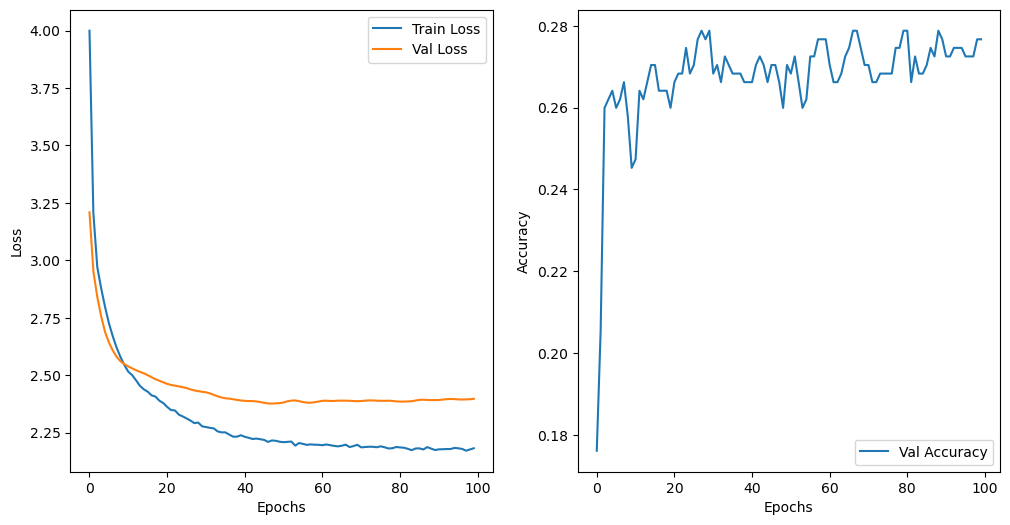

==========================================resutls==========================================
final training loss: 2.182239532470703, final validation loss: 2.397538423538208, final validation accuracy: 0.276729553937912
Average running time" 0.029690897464752196
model complexity(number of parameters): 1197613


In [35]:
get_results(X_val, y_val, char_to_int, int_to_char,
                max_length=10, hidden_size=128, num_layers=2, nhead=4)

Epoch: 10, Train Loss: 2.5305585861206055, Val Loss: 2.6590631008148193, Val Accuracy: 0.21894735097885132
Epoch: 20, Train Loss: 2.368441581726074, Val Loss: 2.536378860473633, Val Accuracy: 0.2210526168346405
Epoch: 30, Train Loss: 2.274042844772339, Val Loss: 2.4861819744110107, Val Accuracy: 0.22736841440200806
Epoch: 40, Train Loss: 2.2248172760009766, Val Loss: 2.4689652919769287, Val Accuracy: 0.22947368025779724
Epoch: 50, Train Loss: 2.1963589191436768, Val Loss: 2.474024534225464, Val Accuracy: 0.23157893121242523
Epoch: 60, Train Loss: 2.187674045562744, Val Loss: 2.4936511516571045, Val Accuracy: 0.22526314854621887
Epoch: 70, Train Loss: 2.1810176372528076, Val Loss: 2.5037832260131836, Val Accuracy: 0.22947368025779724
Epoch: 80, Train Loss: 2.1714160442352295, Val Loss: 2.5077450275421143, Val Accuracy: 0.22947368025779724
Epoch: 90, Train Loss: 2.1657323837280273, Val Loss: 2.5156679153442383, Val Accuracy: 0.22526314854621887
Epoch: 100, Train Loss: 2.166153907775879, 

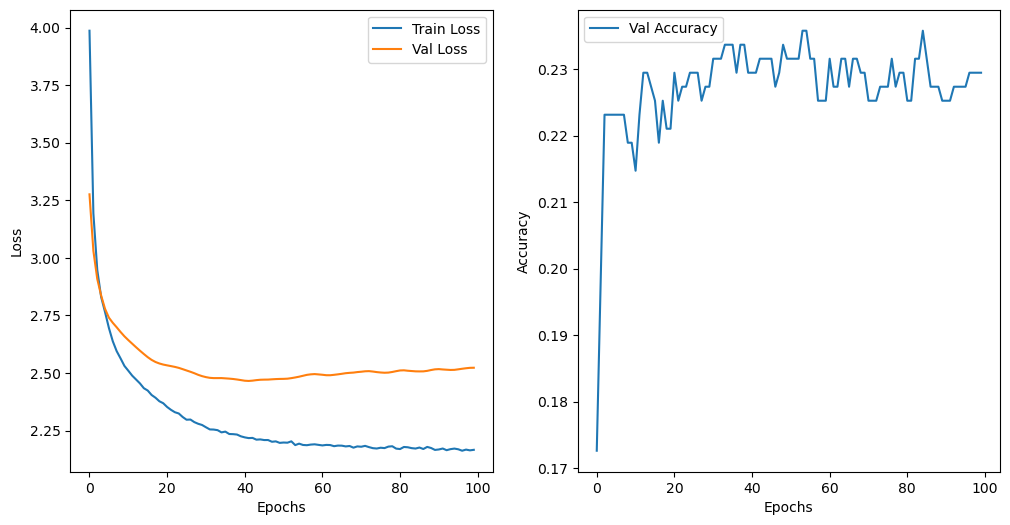

==========================================resutls==========================================
final training loss: 2.166153907775879, final validation loss: 2.5225894451141357, final validation accuracy: 0.22947368025779724
Average running time" 0.05292988300323486
model complexity(number of parameters): 1197613


In [37]:
get_results(X_val, y_val, char_to_int, int_to_char,
                max_length=20, hidden_size=128, num_layers=2, nhead=4)

Epoch: 10, Train Loss: 2.523160457611084, Val Loss: 2.6765315532684326, Val Accuracy: 0.2262156456708908
Epoch: 20, Train Loss: 2.3401193618774414, Val Loss: 2.5791099071502686, Val Accuracy: 0.2241014838218689
Epoch: 30, Train Loss: 2.2477335929870605, Val Loss: 2.5319149494171143, Val Accuracy: 0.23044396936893463
Epoch: 40, Train Loss: 2.2127981185913086, Val Loss: 2.5049245357513428, Val Accuracy: 0.2431289553642273
Epoch: 50, Train Loss: 2.1841607093811035, Val Loss: 2.506924867630005, Val Accuracy: 0.2431289553642273
Epoch: 60, Train Loss: 2.170726776123047, Val Loss: 2.5059728622436523, Val Accuracy: 0.2431289553642273
Epoch: 70, Train Loss: 2.173128366470337, Val Loss: 2.5125620365142822, Val Accuracy: 0.22832980751991272
Epoch: 80, Train Loss: 2.1661648750305176, Val Loss: 2.51214337348938, Val Accuracy: 0.2241014838218689
Epoch: 90, Train Loss: 2.169294834136963, Val Loss: 2.514425277709961, Val Accuracy: 0.23890063166618347
Epoch: 100, Train Loss: 2.1595094203948975, Val Los

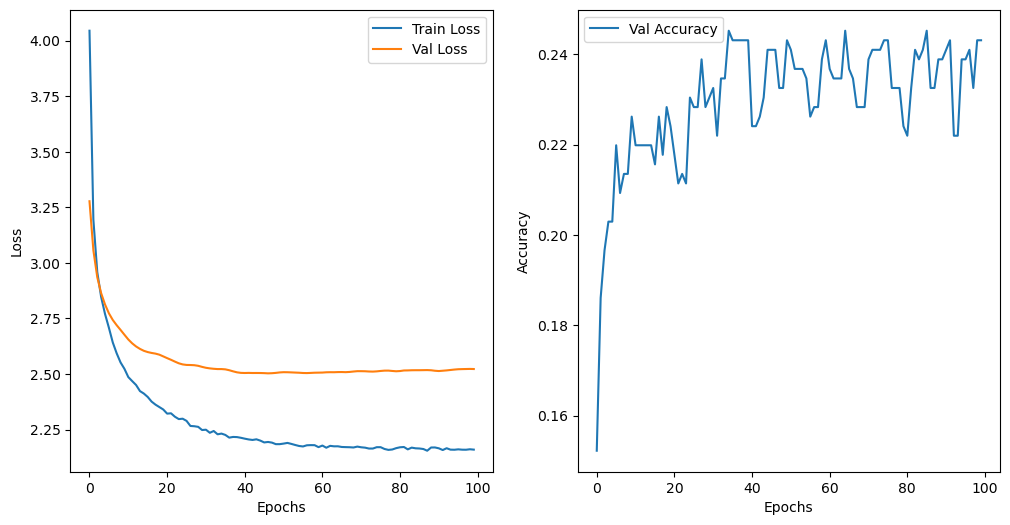

==========================================resutls==========================================
final training loss: 2.1595094203948975, final validation loss: 2.522231101989746, final validation accuracy: 0.2431289553642273
Average running time" 0.0756544041633606
model complexity(number of parameters): 1197613


In [38]:
get_results(X_val, y_val, char_to_int, int_to_char,
                max_length=30, hidden_size=128, num_layers=2, nhead=4)